In [1]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM


true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.01123988 0.01207819 0.01155182 0.02688619 0.
 0.01019029 0.         0.         0.        ]
a = 1.8531667261047913, b = 1.5312904682995265


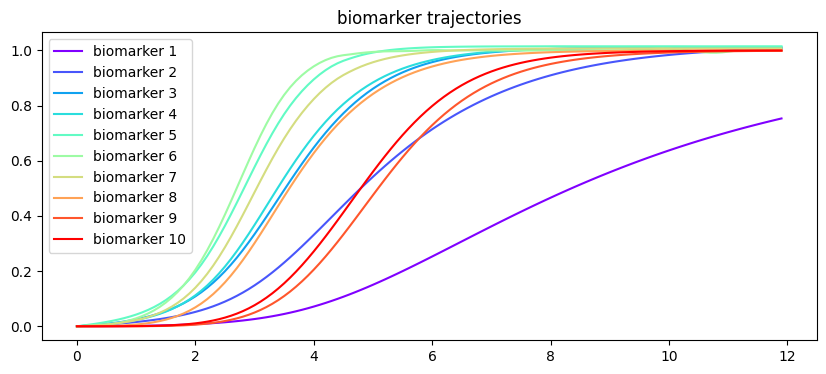

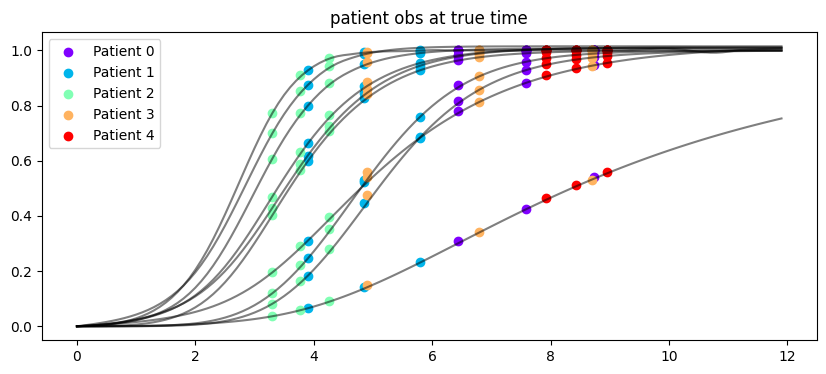

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.04265834 0.03062581 0.13285009 0.13686635 0.18663288 0.150298
 0.18537247 0.18945669 0.1733556  0.0025204 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)


 11%|█         | 2/18 [00:02<00:21,  1.37s/it]

100%|██████████| 18/18 [09:54<00:00, 33.00s/it]


SUMMARY:
initial theta:  [4.26583363e-02 3.06258094e-02 1.32850091e-01 1.36866352e-01
 1.86632880e-01 1.50297999e-01 1.85372474e-01 1.89456689e-01
 1.73355597e-01 2.52039675e-03 1.29863068e+00 2.48683136e+00
 1.65731334e-01 5.03142700e-01 2.95964328e+00 2.98186855e+00
 2.48212827e+00 2.54551839e+00 1.26382145e+00 2.03467892e+00
 2.51363505e+00]
final theta:  [6.09125966e-03 0.00000000e+00 0.00000000e+00 6.04866901e-03
 3.05318301e-02 6.83067751e-07 8.02191971e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.61498821e+00 2.39751016e+00
 1.41584967e+00 1.30747460e+00 1.06955657e+00 1.03792220e+00
 1.13194962e+00 1.36679300e+00 3.23677474e+00 2.65899480e+00
 3.04407364e-01]


EM(lambda_cog=0.0, num_iterations=18, rng=Generator(PCG64) at 0x7F44916CC580)

In [2]:
# params
n_biomarkers = 10
t_max = 12
t_span = np.linspace(0, t_max, 2000)
noise_level = 0.0
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

df, beta_true_dict = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)
plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

biomarker_cols = [col for col in df.columns if col.startswith("biomarker_")]

X = df[biomarker_cols].values
dt = df["dt"].values
ids = df["patient_id"].values
cog = df["cognitive_score"].values
beta_true = df["beta_true"].values

# print(df[biomarker_cols].shape)
# print(df["dt"].shape)
# print(df["patient_id"].shape)
# print(df["cognitive_score"].shape)

em_model_0 = EM(num_iterations=18, t_max=t_max, step=0.01, use_jacobian=True, lambda_cog=0.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

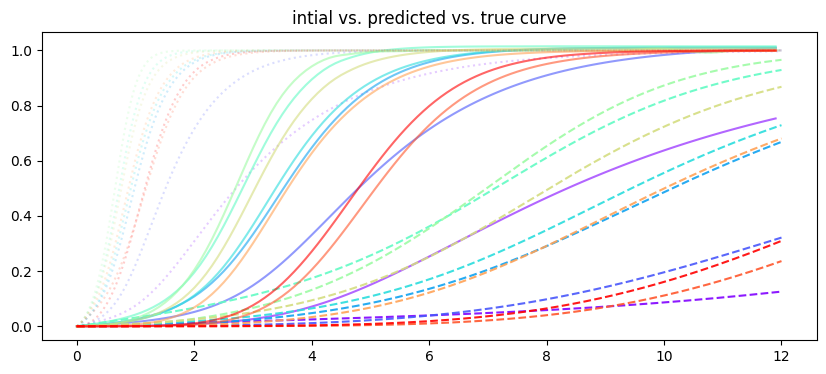

In [3]:
f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
#plot_beta_overlay(df, beta_iter=, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
#plot_beta_error_history(beta_history, em_model_0.num_iterations)
#plot_lse(lse_history)
#plot_cog_regression_history(em_model_0.cog_regression_history_)



In [4]:
print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.006 0.    0.    0.006 0.031 0.    0.008 0.    0.    0.   ]
s:  [2.615 2.398 1.416 1.307 1.07  1.038 1.132 1.367 3.237 2.659]
s_k:  0.30440736449327266

BETA SUMMARY:
beta true:  [6.43  6.43  6.43  3.896 3.896 3.896 3.298 3.298 3.298 4.905]
beta final:  [12.    11.179 10.21  12.    12.    10.069  0.711  9.353  6.641 10.833]


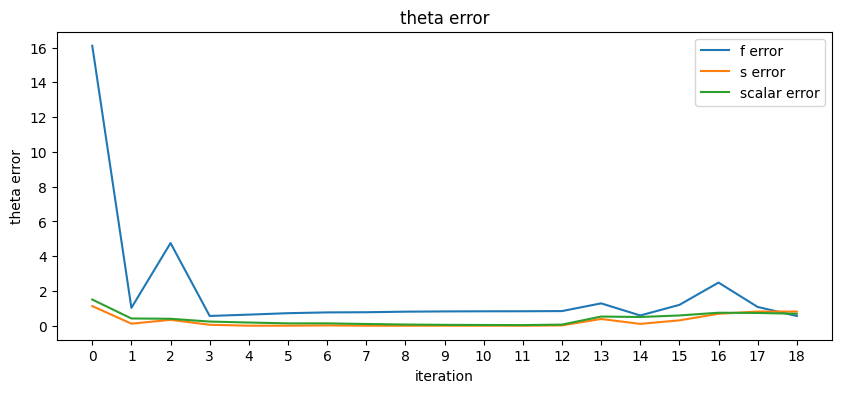

In [5]:
import matplotlib.pyplot as plt

def plot_theta_error_history(theta_history: np.ndarray, n_biomarkers: int,
                             f_true: np.ndarray, s_true: np.ndarray, scalar_K_true: float) -> None:
    """
    Plots normalized error of each parameter group over EM iterations.
    """
    num_iterations = theta_history.shape[1]
    f_error_history = []
    s_error_history = []
    scalar_K_error_history = []

    for iteration in range(num_iterations):
        theta = theta_history[:,iteration]

        f_est = theta[0:n_biomarkers]
        s_est = theta[n_biomarkers:2*n_biomarkers]
        scalar_K_est = theta[-1]

        f_err = np.mean(np.abs(f_true - f_est)) / (np.mean(np.abs(f_true)) + 1e-8)
        s_err = np.mean(np.abs(s_true - s_est)) / (np.mean(np.abs(s_true)) + 1e-8)
        k_err = np.abs(scalar_K_true - scalar_K_est) / (np.abs(scalar_K_true) + 1e-8)

        f_error_history.append(f_err)
        s_error_history.append(s_err)
        scalar_K_error_history.append(k_err)
        
    plt.figure(figsize=(10, 4))
    plt.plot(f_error_history, label="f error")
    plt.plot(s_error_history, label="s error")
    plt.plot(scalar_K_error_history, label="scalar error")
    plt.xticks(range(0,num_iterations))
    plt.title("theta error")
    plt.xlabel("iteration")
    plt.ylabel("theta error")
    plt.legend()
    plt.show()
    
plot_theta_error_history(theta_history=theta_history, n_biomarkers=n_biomarkers,
                         f_true=f, s_true=np.ones(n_biomarkers), scalar_K_true=scalar_K)

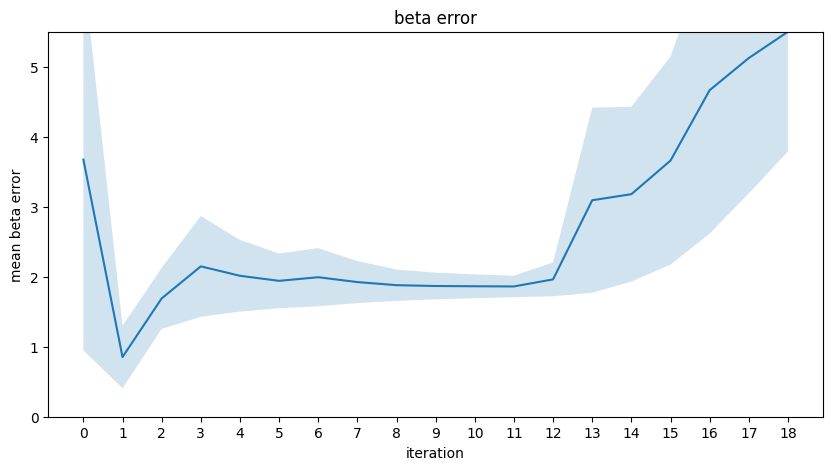

In [6]:
def plot_beta_error_history(beta_history: np.ndarray, beta_true: np.ndarray) -> None:
    """
    Plots mean beta estimation error over EM iterations.
    """
    num_iterations = beta_history.shape[1]
    beta_error_mean_history = np.zeros(num_iterations)
    beta_error_std_history = np.zeros(num_iterations)
    for iteration in range(num_iterations):
        beta_estimated = beta_history[:, iteration]    
        beta_error = np.abs(beta_estimated - beta_true)
        beta_error_mean_history[iteration] = np.mean(beta_error)
        beta_error_std_history[iteration] = np.std(beta_error)

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(beta_error_mean_history)), beta_error_mean_history)
    plt.fill_between(range(len(beta_error_mean_history)),
                     beta_error_mean_history - beta_error_std_history,
                     beta_error_mean_history + beta_error_std_history,
                     alpha = 0.2)
    plt.ylim([0, max(beta_error_mean_history)])
    plt.xticks(range(0,num_iterations))
    plt.xlabel("iteration")
    plt.ylabel("mean beta error")
    plt.title("beta error")
    plt.show()

beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)

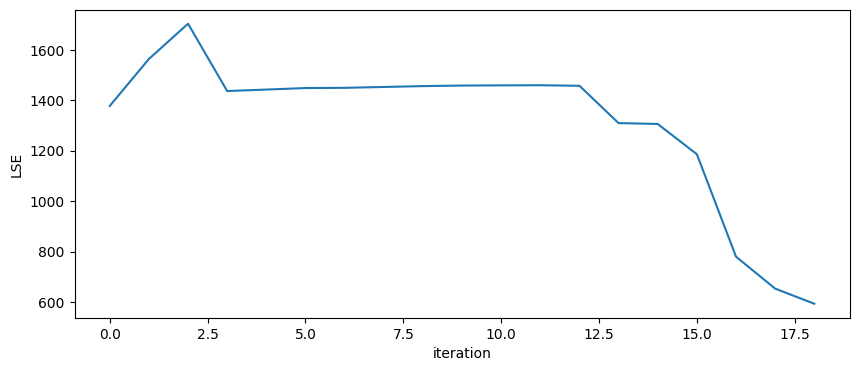

In [7]:
plot_lse(lse_history)